In [ ]:
# pulling from Oracle transaction database at work -- I ran it once, you should read 2 cells down to pull from local drive
import cx_Oracle
import pandas as pd
import yaml
import os 

cred = yaml.load(open(os.path.expanduser('prod_cred.yml')))
conn = cx_Oracle.connect(cred['USER'] + '/' + cred['PW'] + '@PROD')
base = pd.io.sql.read_sql(
    """
    select full_address, assessed_land_value, assessed_total_value, assessed_imp_value, 
        zip, 
        full_bathroom_count + partial_bathroom_count * 0.5 bath,
        bedroom_count as bed,
        2009 - year_built as age,
        stories,
        garage_type,
        parking,
        total_units,
        land_use,
        pool,
        fireplace,
        property_type,
        building_area,
        lot_size,
        fidelity_latitude,
        fidelity_longitude
        
        from bdr.fidelity_assessment_record f
        JOIN bdr.zipcode_city_mapping zcm ON f.zip = zcm.zipcode
        WHERE zcm.mls_table = 'MLS_CA_BA'
        and assessment_year = 2009
        and lot_size > 0
    ORDER BY address_id
    """, conn)

lookup = base.FULL_ADDRESS
base = base.drop('FULL_ADDRESS', axis = 1)

base.to_csv(path_or_buf = 'base.csv')
lookup.to_csv('lookup.csv')

In [2]:
from sklearn.cross_validation import train_test_split

base_l, base_s = train_test_split(base, test_size = 1000, random_state = 32)
base_s = pd.DataFrame(base_s, columns = base.columns)
base_s.to_csv('base_s.csv')

In [3]:
import pandas as pd

try:
    lookup = pd.read_csv('lookup.csv', index_col = 'Unnamed: 0')
    print lookup.head()
except:
    print 'You have no access to the lookup file, which is used for troubleshooting during the exploratory phase only.'

  full_address
0  1529 3RD ST
1  1525 3RD ST
2  1523 3RD ST
3  1519 3RD ST
4  1507 3RD ST


#READ THIS
The full data (base.csv) is too big for GitHub, so I sample 1000 random rows into base_s.csv (using train_test_split) with the step above. If using the full data (not on GitHub), run everything below; if using the sample data, adjust the cell below to read from base_s.csv instead of base.csv.

For most applications, do not run the 2 cells above this one.

I also create and import an address lookup file to help with my exploration. This is not provided on GitHub.

In [5]:
import pandas as pd
from seaborn import plt
import seaborn as sns
%matplotlib inline

base = pd.read_csv('base.csv')
print len(base)
base = base.drop('Unnamed: 0', axis = 1)
base.head().T.to_csv('data_example.csv')
base.head()

1558278


C:\Users\dfeng\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\io\parsers.py:1130: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,LAND_USE,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
0,15464,46393,61857,94607,1.0,2,119,2,G,0,0,1001,NaN,NaN,NaN,572,2500,37.803152,-122.296821
1,90000,210000,300000,94607,0.5,2,119,2,G,0,0,1001,NaN,NaN,NaN,572,2500,37.803141,-122.296767
2,17487,125805,143292,94607,2.0,4,119,2,NaN,0,0,1001,NaN,NaN,NaN,1672,2500,37.803136,-122.296740
3,27290,56096,83386,94607,1.5,4,119,2,NaN,0,0,1001,NaN,NaN,NaN,1144,2500,37.803125,-122.296685
4,18193,37903,56096,94607,2.0,4,129,2,G,0,1,1101,NaN,NaN,NaN,1594,2500,37.803093,-122.296523


In [6]:
base.describe().T

,count,mean,std,min,25%,50%,75%,max
ASSESSED_LAND_VALUE,1558278,173641.223270,306787.064111,0.000000,46616.000000,101761.000000,206400.000000,1.134974e+08
ASSESSED_TOTAL_VALUE,1558278,204622.388653,239538.804009,0.000000,83766.000000,160509.000000,261788.500000,7.808417e+07
ASSESSED_IMP_VALUE,1558278,378263.611922,471608.242032,0.000000,144973.250000,281639.000000,478592.750000,1.134974e+08
ZIP,1558278,94742.482704,392.571872,93109.000000,94534.000000,94597.000000,95051.000000,9.600100e+04
BATH,1558278,1.985419,0.946865,0.000000,1.000000,2.000000,2.500000,2.000000e+01
BED,1558278,2.880011,1.392383,0.000000,2.000000,3.000000,4.000000,2.000000e+01
AGE,1466427,44.196920,24.995731,0.000000,25.000000,43.000000,58.000000,1.990000e+02
PARKING,1558278,1.272550,11.772471,0.000000,0.000000,1.000000,2.000000,2.700000e+03
TOTAL_UNITS,1558278,0.215387,0.933769,0.000000,0.000000,0.000000,0.000000,3.000000e+02
LAND_USE,1558278,1162.220699,1023.554382,1001.000000,1001.000000,1001.000000,1001.000000,8.001000e+03


## Zero-handling Analysis

In [7]:
# how bad are the zeros?

for i in base.columns:
    print i + ': ' + str((base[i] == 0).sum())

ASSESSED_LAND_VALUE: 1694
ASSESSED_TOTAL_VALUE: 41902
ASSESSED_IMP_VALUE: 1669
ZIP: 0
BATH: 98502
BED: 180468
AGE: 486
STORIES: 0
GARAGE_TYPE: 0
PARKING: 650849
TOTAL_UNITS: 1314170
LAND_USE: 0
POOL: 0
FIREPLACE: 0
PROPERTY_TYPE: 0
BUILDING_AREA: 73916
LOT_SIZE: 0
FIDELITY_LATITUDE: 9081
FIDELITY_LONGITUDE: 9081


Large # of properties with no bath, no bed, have to check if it's right or if it's studio.

In [8]:
print zip(lookup.iloc[9], lookup.iloc[19], lookup.iloc[20], lookup.iloc[21], lookup.iloc[22]), lookup.iloc[1558181]
base[base.BED == 0].head()

[('412 BRUSH ST', '373 4TH ST', '373 4TH ST', '373 4TH ST', '373 4TH ST')] full_address    1311 65TH ST
Name: 1558181, dtype: object


,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,LAND_USE,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
9,9139,11251,20390,94607,0,0,119,NaN,NaN,0,0,1001,NaN,NaN,NaN,736,1875,37.800795,-122.281557
19,139200,324800,464000,94607,1,0,100,3,NaN,0,0,1004,NaN,NaN,NaN,1700,8234,37.797090,-122.273072
20,106200,247800,354000,94607,1,0,100,3,NaN,0,0,1004,NaN,NaN,NaN,1500,8234,37.797090,-122.273072
21,24798,235588,260386,94607,1,0,100,3,NaN,0,0,1004,NaN,NaN,NaN,1700,8234,37.797090,-122.273072
22,156000,364000,520000,94607,1,0,100,3,NaN,0,0,1004,NaN,NaN,NaN,1850,8234,37.797090,-122.273072


In [9]:
pd.concat([lookup, base[base.BATH == 0]], join = 'inner', axis = 1).head()

,full_address,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,LAND_USE,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
9,412 BRUSH ST,9139,11251,20390,94607,0,0,119,NaN,NaN,0,0,1001,NaN,NaN,NaN,736,1875.00,37.800795,-122.281557
29,311 4TH ST,87900,205100,293000,94607,0,0,10,1,NaN,0,0,1004,NaN,NaN,NaN,1072,1.03,37.796396,-122.271534
30,126 4TH ST,115500,269500,385000,94607,0,0,10,1,NaN,0,0,1004,NaN,NaN,NaN,1157,1.03,37.795007,-122.267178
31,311 4TH ST,105900,247100,353000,94607,0,0,10,1,NaN,0,0,1004,NaN,NaN,NaN,1061,1.03,37.796396,-122.271534
32,311 4TH ST,123000,287000,410000,94607,0,0,10,1,NaN,0,0,1004,NaN,NaN,NaN,1115,1.03,37.796396,-122.271534


Looking up a few cases reveals that 0 bed/bath tends to be error data, with no immediate pattern (e.g. small, big homes and condos all have this problem). Going to drop them all and not worry about them.

In [10]:
pd.concat([lookup, base[base.STORIES == '0']], axis=1, join = 'inner').head()

,full_address,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,LAND_USE,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
845386,1240 MOUNTAIN VIEW RD,458873,143395,602268,93109,1.75,2,50,0,NaN,0,0,1001,NaN,1,NaN,1344,9148,34.410187,-119.718668
845387,1250 MOUNTAIN VIEW RD,205110,128999,334109,93109,1.75,4,46,0,NaN,0,0,1001,NaN,1,NaN,1542,10019,34.410228,-119.718885
845388,1260 MOUNTAIN VIEW RD,26302,54269,80571,93109,1.75,3,51,0,C,0,0,1001,NaN,NaN,NaN,1244,9583,34.410269,-119.719100
845389,1268 MOUNTAIN VIEW RD,26301,57554,83855,93109,2.00,3,50,0,NaN,0,0,1001,NaN,1,NaN,1242,12632,34.410302,-119.719273
845390,1276 MOUNTAIN VIEW RD,518000,196000,714000,93109,1.75,2,52,0,A,0,0,1001,NaN,1,NaN,1205,13504,34.410335,-119.719446


Stories == 0 seems like bad data (a lot of Santa Barbara addresses, which shouldn't be in here). Remove. In any case, not apparent what the right number should be.

## Error-handling Analysis

In [11]:
len(base) - base.count() # how many errors?

ASSESSED_LAND_VALUE           0
ASSESSED_TOTAL_VALUE          0
ASSESSED_IMP_VALUE            0
ZIP                           0
BATH                          0
BED                           0
AGE                       91851
STORIES                  500500
GARAGE_TYPE              405435
PARKING                       0
TOTAL_UNITS                   0
LAND_USE                      0
POOL                    1426877
FIREPLACE               1342550
PROPERTY_TYPE           1485611
BUILDING_AREA                 0
LOT_SIZE                      0
FIDELITY_LATITUDE             0
FIDELITY_LONGITUDE            0
dtype: int64

In [12]:
test = base[base.AGE.isnull()]
pd.concat([lookup, test], axis = 1, join = 'inner').tail()

,full_address,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,LAND_USE,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
1558271,881 JONES ST,900,2100,3000,94710,0,0,NaN,NaN,NaN,0,0,1001,NaN,NaN,NaN,0,200,37.875534,-122.298624
1558274,6000 GRIZZLY PEAK BLVD,337,0,337,94611,0,0,NaN,NaN,NaN,0,0,1001,NaN,NaN,NaN,0,809,37.852437,-122.208045
1558275,GRIZZLY PEAK BLVD,146112,2526,148638,94611,0,0,NaN,NaN,NaN,0,0,1999,NaN,NaN,NaN,0,17071,37.852205,-122.207129
1558276,9TH ST,2665,1142,3807,94710,0,0,NaN,NaN,NaN,0,0,1999,NaN,NaN,NaN,0,2410,37.869705,-122.293922
1558277,2333 VINE ST,29321,4950,34271,94708,0,0,NaN,NaN,NaN,0,0,1999,NaN,NaN,NaN,0,4037,37.881073,-122.263458


Missing Age data appears non-trivial; cross-reference of test cases with other data sources shows there should be an age. Raw data probably not right, impute by removing records with missing-age data

In [13]:
print base.STORIES.value_counts()

1       387807
1.0     285379
2       193544
2.0     102671
1.5      60710
3        11036
3.0       5048
2+B       3455
0         1972
2.5       1765
1+B       1304
4.0       1258
2+         468
3+B        385
5.0        272
4          179
25.0       149
11.0       118
3.5         53
12.0        53
17.0        30
1.5         24
7.0         17
5           13
8.0         13
6.0         12
20.0        10
6            6
8            5
4.5          3
93.0         2
10.0         2
9.0          2
2.5          2
12           2
31.0         1
9            1
11           1
S/L          1
20           1
7            1
15           1
6.5          1
23.0         1
dtype: int64


In [15]:
pd.concat([lookup, base[base.STORIES > 50]], join = 'inner', axis = 1).head()

,full_address,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,LAND_USE,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
722298,2360 W TWITCHELL ISLAND RD,85711,171599,257310,94571,3.0,4,44,1,G,1,0,1008,P,Y,NaN,2618,10.88,38.123537,-121.665171
722299,18110 SHRMN IS E LV RD,23497,73951,97448,94571,2.0,3,64,1,G,8,0,1008,NaN,NaN,NaN,1666,25.00,38.091531,-121.712234
722300,18075 STATE HIGHWAY 160,157965,470185,628150,94571,2.0,3,5,2,G,9,0,1008,NaN,NaN,NaN,3096,3.87,38.098581,-121.704634
722301,17210 SHRMN IS E LV RD,91772,525751,617523,94571,2.5,4,4,2,G,3,0,1101,NaN,Y,NaN,3190,2.05,38.098581,-121.704634
722302,4361 LELIA DR,4952,23044,27996,94571,1.0,3,49,2,NaN,0,0,1001,NaN,Y,NaN,1150,5415.00,38.074422,-121.753927


Have to clean up the '+B' and convert to float. Not sure what 0.5 means but roll with it

In [16]:
pd.concat([lookup, base[base.STORIES.isnull()]], join = 'inner', axis = 1).tail(5)

,full_address,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,LAND_USE,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
1558273,6000 GRIZZLY PEAK BLVD,207728,629820,837548,94611,3,3,38,NaN,NaN,0,0,1001,NaN,NaN,NaN,1925,16842,37.852437,-122.208045
1558274,6000 GRIZZLY PEAK BLVD,337,0,337,94611,0,0,NaN,NaN,NaN,0,0,1001,NaN,NaN,NaN,0,809,37.852437,-122.208045
1558275,GRIZZLY PEAK BLVD,146112,2526,148638,94611,0,0,NaN,NaN,NaN,0,0,1999,NaN,NaN,NaN,0,17071,37.852205,-122.207129
1558276,9TH ST,2665,1142,3807,94710,0,0,NaN,NaN,NaN,0,0,1999,NaN,NaN,NaN,0,2410,37.869705,-122.293922
1558277,2333 VINE ST,29321,4950,34271,94708,0,0,NaN,NaN,NaN,0,0,1999,NaN,NaN,NaN,0,4037,37.881073,-122.263458


Found examples of 1- and 2-storey buildings which are null in my data, looks like it's due to outdated raw data, so removing. It looks particularly ill-defined for condos and multi-family residences.

In [17]:
base.PROPERTY_TYPE.value_counts()

SFR    42063
PUD    12089
CND     9549
MFD     6318
RES     1680
2ND      934
MFG       25
MOH        4
LAN        3
COM        1
AGR        1
dtype: int64

PROPERTY_TYPE does not look useful, the missing data appears to be non-trivial<br>
**update** Thanks to this, found out from engineer that I should use LAND_USE, and got a dictionary out of it.

In [18]:
base.LAND_USE.value_counts()

1001    1205326
1004     131920
1009      60703
8001      34048
1008      32997
1110      32492
1101      31285
1002      13076
1103       7041
1102       4864
1999       3888
1006        295
1016        235
1005        108
dtype: int64

In [23]:
lu_ptype = {
            1001 : 'SFR',
            1002 : 'TOWNHOUSE',
            1003 : 'CLUSTER HOME',
            1004 : 'CONDO',
            1005 : 'COOP',
            1006 : 'MOBILE',
            1007 : 'ROW HOUSE',
            1009 : 'SFR-PUD',
            1101 : 'MFR',
            1102 : 'MFR',
            1103 : 'MFR',
            1110 : 'MFR'
            }

base['ptype'] = base.LAND_USE.map(lu_ptype)
base.ptype

0       SFR
1       SFR
2       SFR
3       SFR
4       MFR
5       MFR
6       MFR
7       SFR
8       MFR
9       SFR
10      SFR
11      MFR
12    CONDO
13      SFR
14      SFR
...
1558263    TOWNHOUSE
1558264    TOWNHOUSE
1558265    TOWNHOUSE
1558266    TOWNHOUSE
1558267    TOWNHOUSE
1558268          SFR
1558269          SFR
1558270        CONDO
1558271          SFR
1558272          SFR
1558273          SFR
1558274          SFR
1558275          NaN
1558276          NaN
1558277          NaN
Name: ptype, Length: 1558278, dtype: object

In [26]:
print len(base[base.ptype.isnull()])
print len(base[base.LAND_USE.isnull()])
print base.ptype.value_counts()

71168
0
SFR          1205326
CONDO         131920
MFR            75682
SFR-PUD        60703
TOWNHOUSE      13076
MOBILE           295
COOP             108
dtype: int64


In [36]:
print base.LAND_USE[base.ptype.isnull()].value_counts()
print base.PROPERTY_TYPE.value_counts()
print base.PROPERTY_TYPE[base.ptype.isnull()].value_counts()
base[(base.ptype.isnull()) & (base.ASSESSED_TOTAL_VALUE == 0)].tail()

8001    34048
1008    32997
1999     3888
1016      235
dtype: int64
SFR    42063
PUD    12089
CND     9549
MFD     6318
RES     1680
2ND      934
MFG       25
MOH        4
LAN        3
COM        1
AGR        1
dtype: int64
SFR    706
PUD    192
2ND    139
MFD     63
RES     27
MFG      7
CND      4
LAN      2
dtype: int64


,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,LAND_USE,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE,ptype
1558233,9544,0,9544,94806,0,0,NaN,NaN,NaN,0,0,8001,NaN,NaN,NaN,0,2500.0,37.971278,-122.343621,NaN
1558236,1530000,0,1530000,94563,0,0,NaN,NaN,NaN,0,0,8001,NaN,NaN,NaN,0,1.1,37.900615,-122.194385,NaN
1558238,70775,0,70775,94563,0,0,NaN,NaN,NaN,0,0,8001,NaN,NaN,NaN,0,41800.0,37.894282,-122.207369,NaN
1558244,61428,0,61428,94553,0,0,NaN,NaN,NaN,0,0,8001,NaN,NaN,NaN,0,5175.0,38.007590,-122.116865,NaN
1558246,4226,0,4226,94803,0,0,NaN,NaN,NaN,0,0,8001,NaN,NaN,NaN,0,5400.0,37.963988,-122.293365,NaN


In [143]:
print base.GARAGE_TYPE.value_counts()
print len(base[base.GARAGE_TYPE.isnull()])

G    736371
Y    357703
C     34295
V     19365
M      4455
O       322
A       273
D        55
B         2
N         2
dtype: int64
405435


In [144]:
print base.POOL.value_counts()
print len(base[base.POOL.isnull()])

P    122689
B      7537
S      1154
H        21
dtype: int64
1426877


In [145]:
print base.FIREPLACE.value_counts()
print len(base[base.FIREPLACE.isnull()])

Y      112459
1.0     60897
1       30419
2.0      6787
2        3599
3.0       836
3         559
4.0        79
4          65
5.0        12
5           6
6           4
6.0         2
7.0         1
9.0         1
7           1
9           1
dtype: int64
1342550


In [146]:
print base.TOTAL_UNITS.value_counts()
print len(base[base.TOTAL_UNITS.isnull()])

0     1314170
1      192791
2       32722
4       11340
3        6567
5         157
6         103
8          71
7          45
10         43
9          31
12         25
11         18
16         12
32         11
...
111    1
37     1
109    1
100    1
99     1
98     1
76     1
72     1
71     1
66     1
64     1
48     1
47     1
254    1
43     1
Length: 82, dtype: int64
0


In [71]:
print base.PARKING.value_counts()
print len(base[base.PARKING.isnull()])
pd.concat([lookup, base[base.PARKING < 50]], join = 'inner', axis = 1).sort(columns = 'PARKING').tail(5).T

2     651750
0     650849
1     188775
3      44473
4      16762
5       2822
6       1147
7        396
8        309
9         95
24        72
76        67
10        61
22        59
13        48
...
1364    1
340     1
336     1
330     1
329     1
325     1
320     1
688     1
307     1
300     1
289     1
588     1
286     1
282     1
379     1
Length: 225, dtype: int64
0


,1004069,1255046,1144625,1026391,908912
full_address,645 NIDO DR,14255 SYCAMORE DR,14777 MONTALVO RD,23019 VOSS AVE,751 LOS ALTOS AVE
ASSESSED_LAND_VALUE,159184,341600,770372,1000000,567268
ASSESSED_TOTAL_VALUE,363863,417600,903437,237000,609291
ASSESSED_IMP_VALUE,523047,759200,1673809,1237000,1176559
ZIP,95008,95037,95070,95014,94022
BATH,0,2.5,3.5,2.5,3
BED,0,4,4,4,3
AGE,44,21,32,28,18
STORIES,2,1,1,2,1
GARAGE_TYPE,V,G,G,G,G


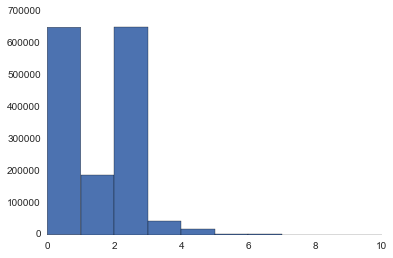

In [75]:
base.PARKING[base.PARKING <= 10].hist()

In [148]:
pd.concat([lookup, base[base.TOTAL_UNITS.isnull()]], join = 'inner', axis = 1).tail(5)
pd.concat([lookup, base[base.TOTAL_UNITS == 111]], join = 'inner', axis = 1).tail(5)

,full_address,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
1510456,8200 FOOTHILL RANCH RD,449888,489253,939141,95404,3,3,22,1,NaN,0,111,NaN,1,NaN,2614,9.67,38.519323,-122.677983


## Derivative Metrics
I notice lot_size appears to be sometimes in sq ft, sometimes in acres. Using the rule below to catch them, but it's not perfect. Going to remove all cases where BUILDING_AREA > LOT_SIZE (BUILDING_AREA looks wrong sometimes too), which might bias against condos, MFRs.

In [5]:
base[base.LOT_SIZE < base.BUILDING_AREA].head()
test = pd.concat([lookup, base[(base.LOT_SIZE < base.BUILDING_AREA) & (base.LOT_SIZE < 100)]], join = 'inner', axis = 1)
# test = pd.concat([lookup, base[base.LOT_SIZE < base.BUILDING_AREA / 10]], join = 'inner', axis = 1)
test2 = test.sort(columns = ['LOT_SIZE'], ascending = False)
test2.head()

,full_address,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
701510,2990 MONTICELLO RD,82498,57479,139977,94558,1.0,1,29,NaN,NaN,0,0,NaN,NaN,NaN,896,99.010002,38.338386,-122.295914
68502,4601 GRASS VALLEY RD,129975,233754,363729,94605,3.5,4,21,1,G,0,0,P,NaN,NaN,2993,94.970001,37.750859,-122.121664
700525,6210 DRY CREEK RD,117577,102120,219697,94558,2.0,1,52,NaN,NaN,0,0,P,Y,NaN,1128,94.680000,38.408119,-122.441856
350771,1963 CYPRESS CT,54982,204608,259590,94561,3.0,5,21,NaN,Y,2,0,NaN,NaN,NaN,2345,91.959999,37.989829,-121.730608
972313,810 WASHINGTON ST,23902,50813,74715,95050,1.0,2,NaN,1,G,2,0,NaN,NaN,NaN,1357,91.199997,37.347996,-121.942794


In [7]:
# Trying to tease out acres by 2 decimal paces. Did not work, 
# there are acres with >2 decimal places and sq ft with 2 decimal places.

def acres_finder(num):
    import re
    if re.search('.+\...$', str(num)):
        return 1

test = base.LOT_SIZE.map(acres_finder)
base[test == 1].sort(columns = 'LOT_SIZE', ascending = False).head()

,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,TOTAL_UNITS,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE
800627,67611,118335,185946,94110,2,0,94,2,NaN,0,0,NaN,NaN,NaN,1505,1331.53,37.748606,-122.408093
655042,149199,246616,395815,94952,0,0,NaN,NaN,NaN,0,2,NaN,NaN,NaN,0,483.91,38.154225,-122.714554
1283990,173551,419527,593078,94571,2,2,4,NaN,G,2,0,NaN,NaN,NaN,2680,474.97,38.198221,-121.783699
1539193,228943,51585,280528,94956,0,0,NaN,NaN,NaN,0,2,NaN,NaN,NaN,0,471.25,0.000000,0.000000
652103,123381,614385,737766,94952,3,3,18,NaN,Y,3,2,NaN,NaN,NaN,4319,438.25,38.202801,-122.779729


##Processing

In [17]:
print len(base)

basef = base

basef = basef[basef.ASSESSED_TOTAL_VALUE > 0] # remove Land
basef = basef[basef.FIDELITY_LATITUDE > 0] # remove properties with no lat/long information
basef = basef[basef.ASSESSED_LAND_VALUE > 0] # remove properties with no land value
basef = basef[basef.BUILDING_AREA > 0] # remove properties with no land value
basef = basef[basef.BED > 0]
basef = basef[basef.BATH > 0]
basef = basef[basef.STORIES > 0]

print '\nRemoved:'
print 'ASSESSED_TOTAL_VALUE: ' + str(len(base[base.ASSESSED_TOTAL_VALUE == 0]))
print 'FIDELITY_LATITUDE: ' + str(len(base[base.FIDELITY_LATITUDE == 0]))
print 'ASSESSED_LAND_VALUE: ' + str(len(base[base.ASSESSED_LAND_VALUE == 0]))
print 'BUILDING_AREA: ' + str(len(base[base.BUILDING_AREA == 0]))
print 'BED: ' + str(len(base[base.BED == 0]))
print 'BATH: ' + str(len(base[base.BATH == 0]))
print 'STORIES: ' + str(len(base[base.STORIES == 0]))

print '\nRemaining:'
for i in basef.columns:
    print i + ': ' + str((basef[i] == 0).sum())
    
print len(basef)

1558278

Removed:
ASSESSED_TOTAL_VALUE: 41902
FIDELITY_LATITUDE: 9081
ASSESSED_LAND_VALUE: 1694
BUILDING_AREA: 73916
BED: 180468
BATH: 98502
STORIES: 0

Remaining:
ASSESSED_LAND_VALUE: 0
ASSESSED_TOTAL_VALUE: 0
ASSESSED_IMP_VALUE: 0
ZIP: 0
BATH: 0
BED: 0
AGE: 323
STORIES: 0
GARAGE_TYPE: 0
PARKING: 430100
TOTAL_UNITS: 821309
POOL: 0
FIREPLACE: 0
PROPERTY_TYPE: 0
BUILDING_AREA: 0
LOT_SIZE: 0
FIDELITY_LATITUDE: 0
FIDELITY_LONGITUDE: 0
landval_perc: 0
lot_perc: 435
950996


In [20]:
basef2 = basef

basef2 = basef2[basef2.AGE.notnull()]

basef2 = basef2[basef2.STORIES != 'S/L']
basef2.STORIES = basef2.STORIES.replace(r'\+B*', '', regex = True)
basef2.STORIES = basef2.STORIES.astype(float)
print basef2.STORIES.value_counts()

1.0     605660
2.0     261561
1.5      59918
3.0      11209
0.0       1819
2.5       1652
4.0        901
5.0        237
25.0       147
11.0       118
12.0        55
3.5         53
17.0        30
6.0         14
7.0         12
20.0        10
8.0          8
4.5          3
10.0         2
93.0         2
6.5          1
9.0          1
23.0         1
31.0         1
dtype: int64


In [36]:
# looks like lot size has mixed units (feet, acres): I'll attempt to convert acres to feet using the following rule:
basef2['lsize_sqft'] = basef2.LOT_SIZE.apply(lambda x: x * 43560 if x < 100 and x < basef2.BUILDING_AREA.iteritems() else x)

basef2['landval_perc'] = basef2.ASSESSED_LAND_VALUE / basef2.ASSESSED_IMP_VALUE
basef2['lot_perc'] = 1 - basef2.BUILDING_AREA / basef2.lsize_sqft

In [62]:
print len(basef2[basef2.BUILDING_AREA > basef2.lsize_sqft])
basef2[basef2.BUILDING_AREA > basef2.lsize_sqft].sort(columns = 'BUILDING_AREA', ascending = False).tail()
print len(basef2[basef2.lot_perc < -0.1])
basef2[(basef2.lot_perc > -0.1) & (basef2.lot_perc < 0.)].sort(columns = 'BUILDING_AREA', ascending = False).head()
basef2[(basef2.lot_perc <= -1)].sort(columns = 'BUILDING_AREA', ascending = False).tail()

58438
49904


,ASSESSED_LAND_VALUE,ASSESSED_TOTAL_VALUE,ASSESSED_IMP_VALUE,ZIP,BATH,BED,AGE,STORIES,GARAGE_TYPE,PARKING,...,POOL,FIREPLACE,PROPERTY_TYPE,BUILDING_AREA,LOT_SIZE,FIDELITY_LATITUDE,FIDELITY_LONGITUDE,landval_perc,lot_perc,lsize_sqft
254662,53700,125300,179000,94536,1,1,24,3,G,0,...,P,NaN,NaN,714,355,37.563434,-122.003929,0.3000,-1.011268,355
254658,53700,125300,179000,94536,1,1,24,3,G,0,...,P,NaN,NaN,714,355,37.561278,-122.004148,0.3000,-1.011268,355
254643,60000,140000,200000,94536,1,1,24,3,G,0,...,P,NaN,CND,714,355,37.561570,-122.004053,0.3000,-1.011268,355
254639,53700,125300,179000,94536,1,1,24,3,G,0,...,P,NaN,NaN,714,355,37.561874,-122.004279,0.3000,-1.011268,355
254674,66035,67883,133918,94536,1,1,24,3,G,0,...,P,NaN,NaN,714,355,37.561278,-122.004148,0.4931,-1.011268,355


In [63]:
basef2 = basef2[basef2.lot_perc >= -0.1]
len(basef2)

893511

In [78]:
print len(basef2[basef2.PARKING > 10])
basef2 = basef2[basef2.PARKING <= 10]

330


## Setting X up plus PCA

In [81]:
# creating advanced metrics, then defining which I'll use to model

metrics = ['ASSESSED_IMP_VALUE',
           'landval_perc',
           'BED',
           'BATH',
           'AGE',
           'STORIES',
           # 'GARAGE_TYPE',
           'PARKING',
           'TOTAL_UNITS',
           # 'POOL',
           # 'FIREPLACE',
           'BUILDING_AREA',
           'lot_perc']

X = basef2[metrics]
basef2[metrics].head()

,ASSESSED_IMP_VALUE,landval_perc,BED,BATH,AGE,STORIES,PARKING,TOTAL_UNITS,BUILDING_AREA,lot_perc
0,61857,0.249996,2,1.0,119,2,0,0,572,0.7712
1,300000,0.300000,2,0.5,119,2,0,0,572,0.7712
2,143292,0.122038,4,2.0,119,2,0,0,1672,0.3312
3,83386,0.327273,4,1.5,119,2,0,0,1144,0.5424
4,56096,0.324319,4,2.0,129,2,0,1,1594,0.3624


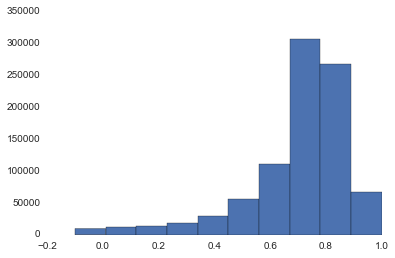

In [82]:
basef2.lot_perc.hist()

In [83]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893181 entries, 0 to 1558272
Data columns (total 10 columns):
ASSESSED_IMP_VALUE    893181 non-null float64
landval_perc          893181 non-null float64
BED                   893181 non-null int64
BATH                  893181 non-null float64
AGE                   893181 non-null float64
STORIES               893181 non-null float64
PARKING               893181 non-null int64
TOTAL_UNITS           893181 non-null int64
BUILDING_AREA         893181 non-null int64
lot_perc              893181 non-null float64
dtypes: float64(6), int64(4)

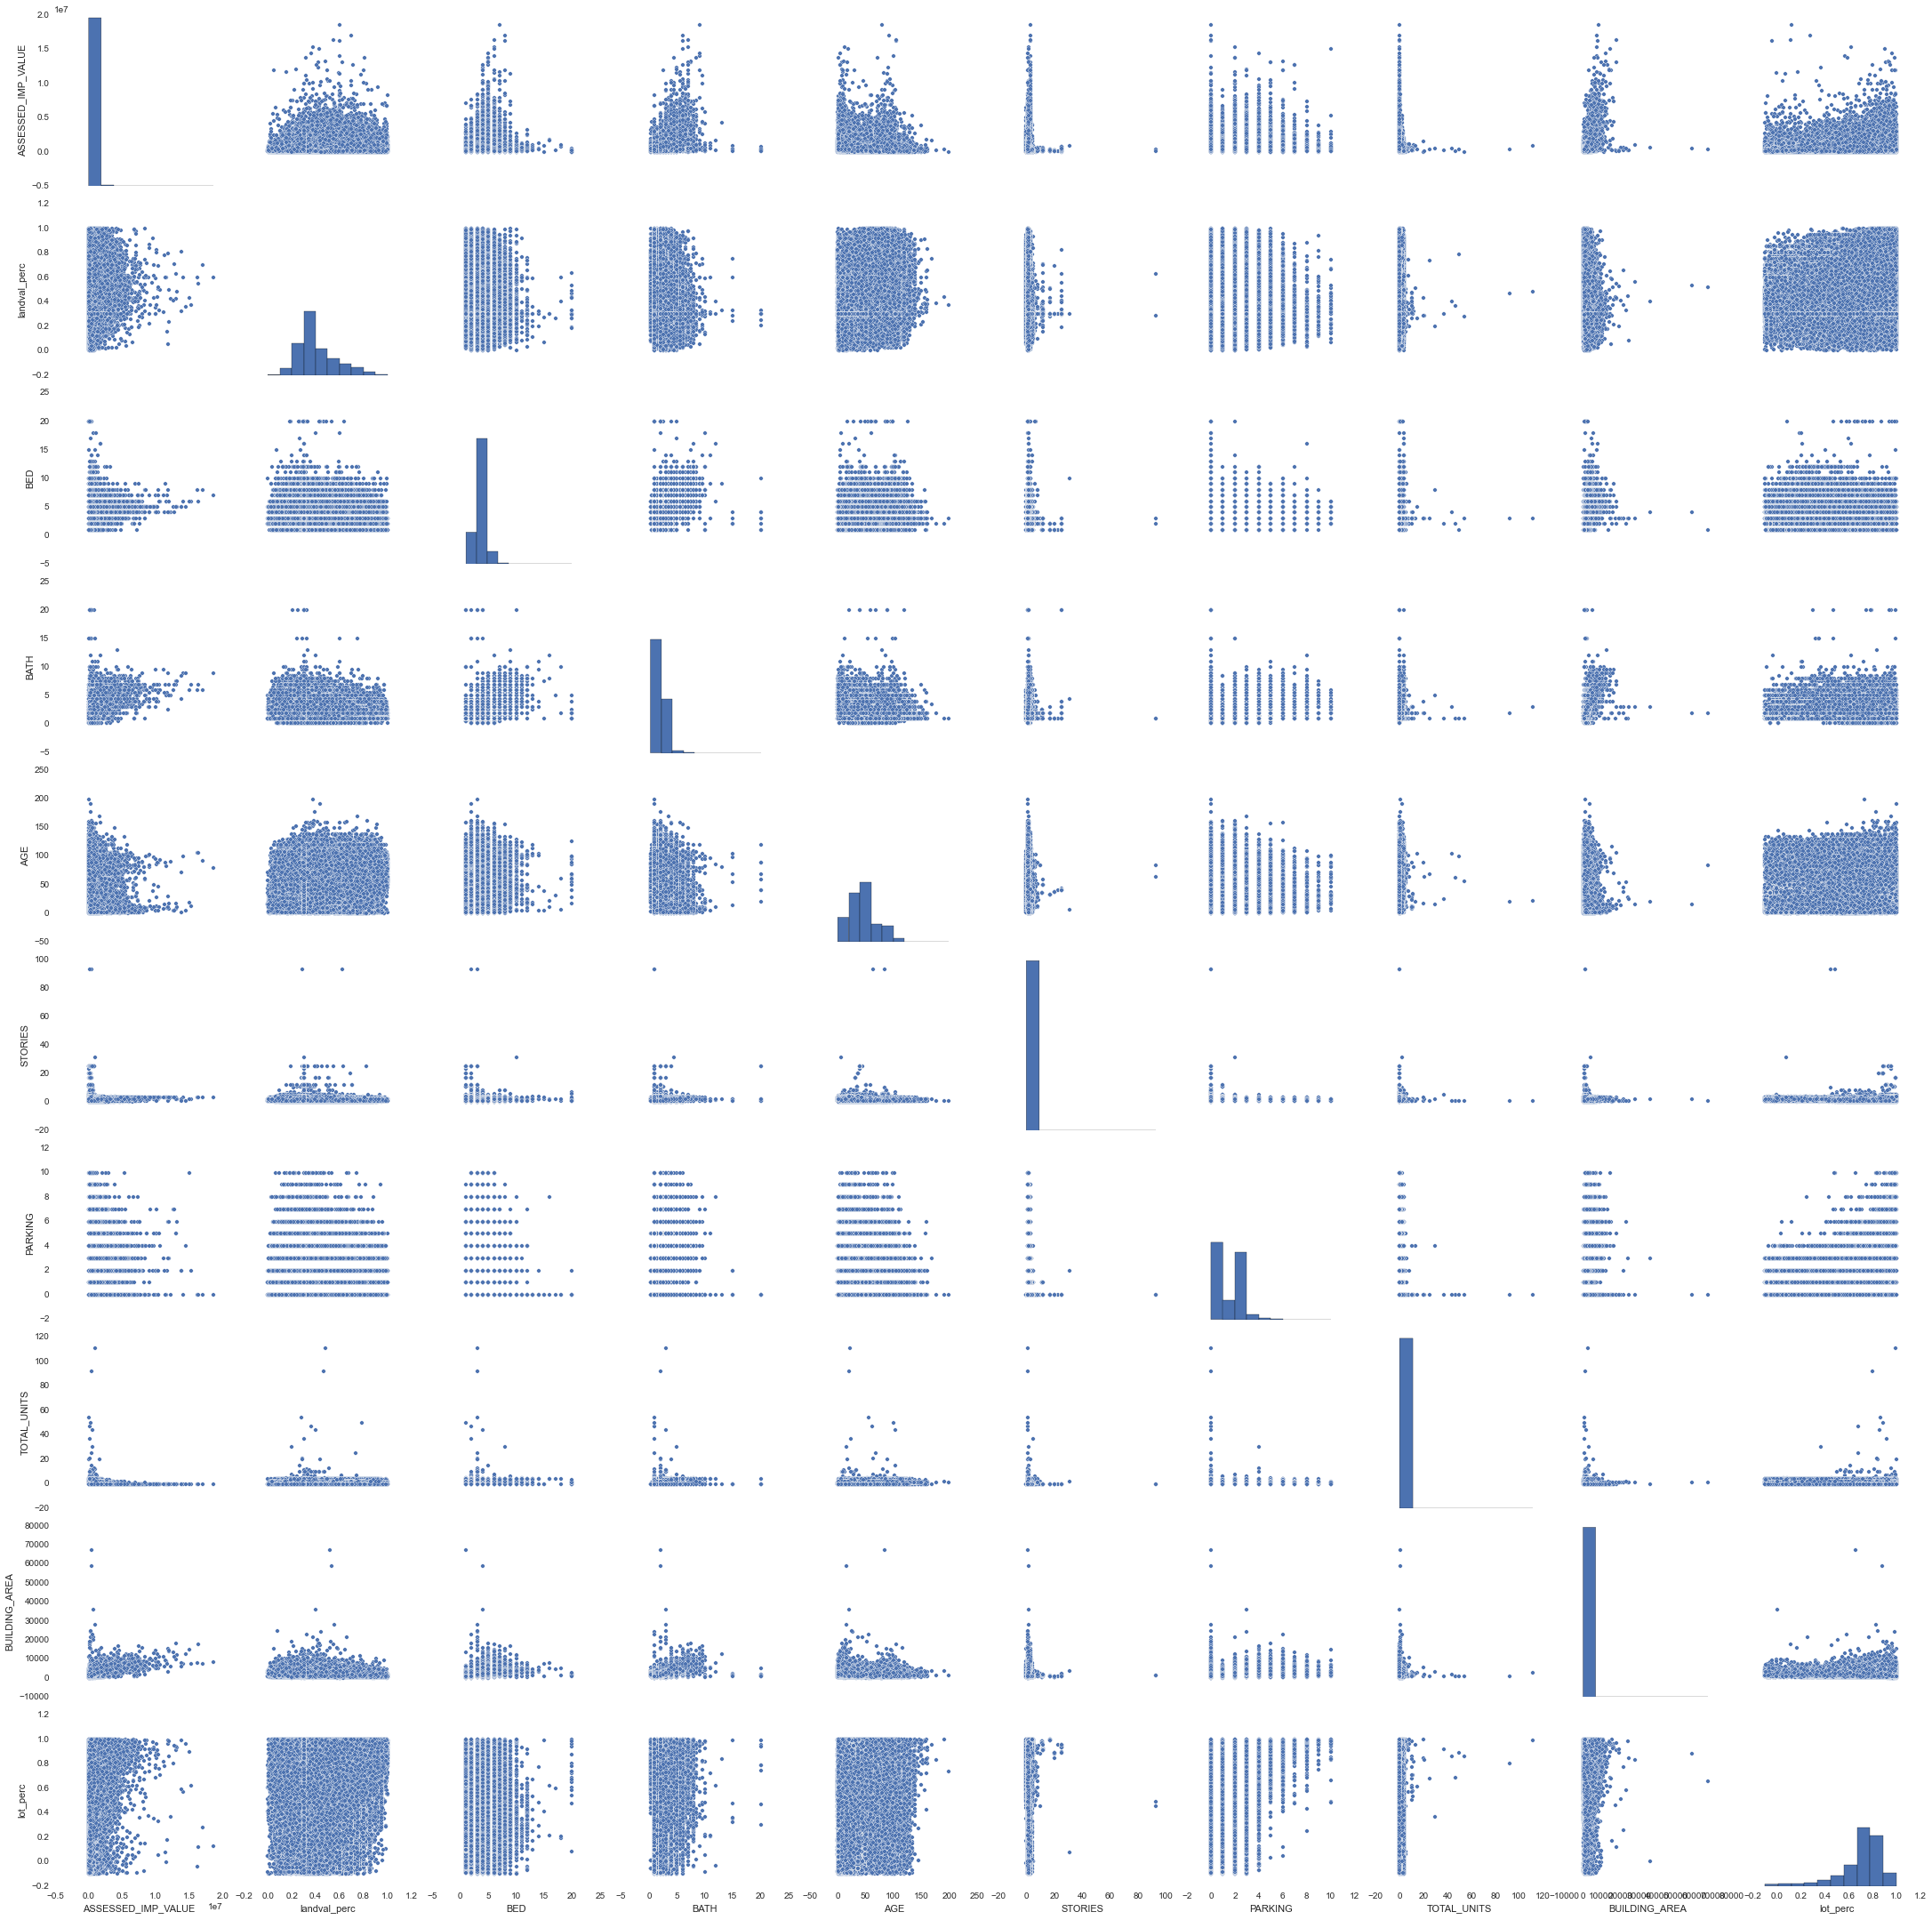

In [87]:
plt.figure(figsize=(18,18))
sns.pairplot(X)

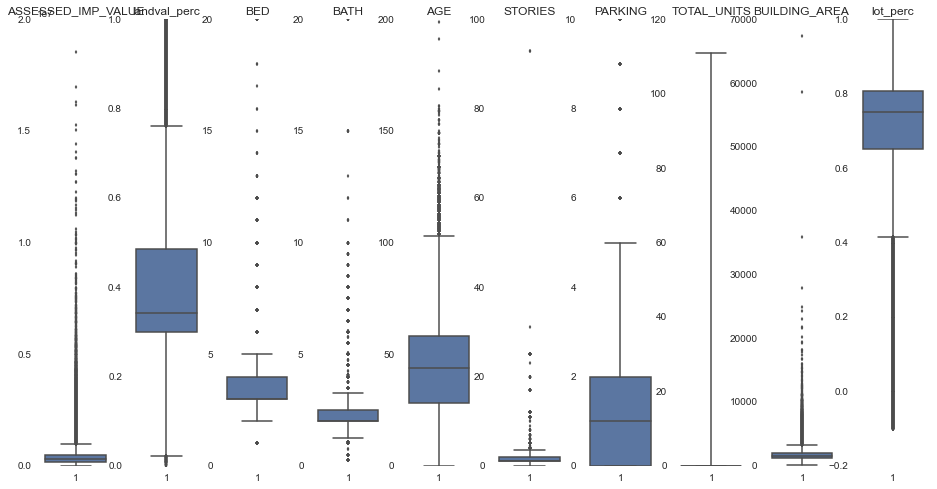

In [106]:
fig = plt.figure(figsize=(16,8))

for i in range(len(X.columns)):
    ax = fig.add_subplot(1, len(X.columns), i+1)
    sns.boxplot(X.iloc[:,i])
    ax.set_title(X.columns[i])

In [110]:
X.STORIES.describe()
# X.TOTAL_UNITS.describe()

count    893181.000000
mean          1.320719
std           0.611607
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          93.000000
dtype: float64

Throw out anything outside of 5 stdev (right side) because it still doesn't make sense

In [119]:
from sklearn.preprocessing import scale

X_scaled = scale(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
ASSESSED_IMP_VALUE,893181,-5.283044e-17,1.000001,-1.005864,-0.599058,-0.228463,0.282061,48.541298
landval_perc,893181,-6.316423e-16,1.000001,-2.489744,-0.607820,-0.343608,0.551824,3.783010
BED,893181,5.326797e-17,1.000001,-2.352992,-0.271334,-0.271334,0.769494,17.422752
BATH,893181,-7.247579e-17,1.000001,-2.328761,-0.123214,-0.123214,0.506942,22.562412
AGE,893181,1.476484e-16,1.000001,-1.883140,-0.721618,-0.057891,0.522870,6.371964
STORIES,893181,3.258447e-17,1.000001,-2.159426,-0.524388,-0.524388,1.110651,149.899163
PARKING,893181,-1.025265e-16,1.000001,-0.989474,-0.989474,-0.033608,0.922258,8.569189
TOTAL_UNITS,893181,-3.753260e-17,1.000001,-0.330123,-0.330123,-0.330123,-0.330123,211.571000
BUILDING_AREA,893181,1.365270e-16,1.000001,-2.128806,-0.664282,-0.223064,0.412183,87.256340
lot_perc,893181,-5.753255e-16,1.000001,-4.259314,-0.269914,0.257777,0.568906,1.586300


In [123]:
print len(X[X_scaled.STORIES > 5]) + len(X[X_scaled.TOTAL_UNITS > 5])
XS = X[(X_scaled.STORIES <= 5) | (X_scaled.TOTAL_UNITS <= 5)]

6427


In [125]:
from sklearn.decomposition import PCA

pca = PCA(whiten = True)
pca.fit(XS)

PCA(copy=True, n_components=None, whiten=True)

In [126]:
pca.explained_variance_ratio_

array([  9.99997294e-01,   2.70171844e-06,   3.78540500e-09,
         6.67925073e-12,   4.26987296e-12,   2.40050284e-12,
         1.70794576e-12,   1.28704622e-12,   2.25563429e-13,
         1.39398293e-13])

In [124]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

pca_pipe = Pipeline((
                     ( 'scl', StandardScaler() ),
                     ( 'pca', PCA(whiten = True) )
                    ))

X_pca = pca_pipe.fit(XS)

In [ ]:
X_pca.ex

#Caveats about Data
I can't distinguish between SFR, MFR, CONDO, TOWNHOUSE etc because property_type is badly populated. I do have this internally, and can even use a classification problem to label my data, but going to roll with it. This means BUILDING_AREA and LOT_SIZE metrics might be off.

###Processing

Disregarded these columns:
 - property_type
 - zip

Removed properties with:
 - no land value
 - no imp_value
 - no bedrooms
 - no bathrooms
 - building_area
 
Imputation